In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

import util.RAVDESS_dataset_util as Rd
import multimodal_vae
from train_mvae import build_model, train

from config_args import ConfigModelArgs, ConfigTrainArgs
import torch_mvae_util as U

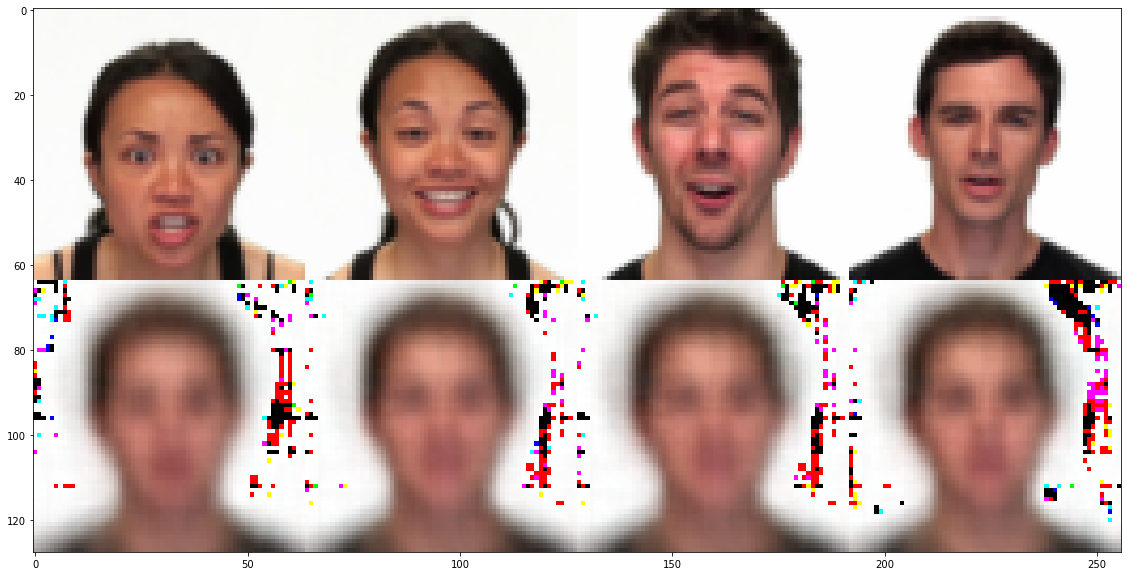

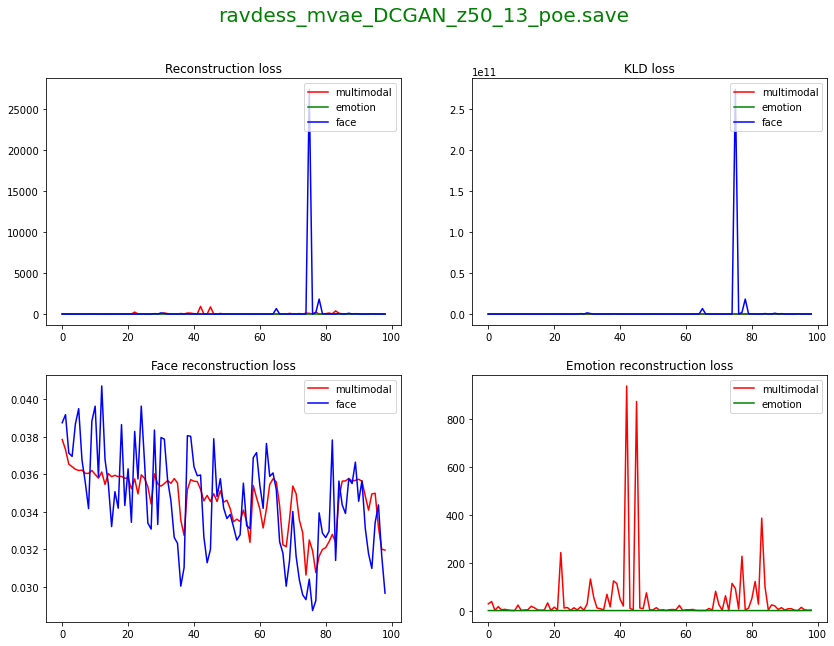

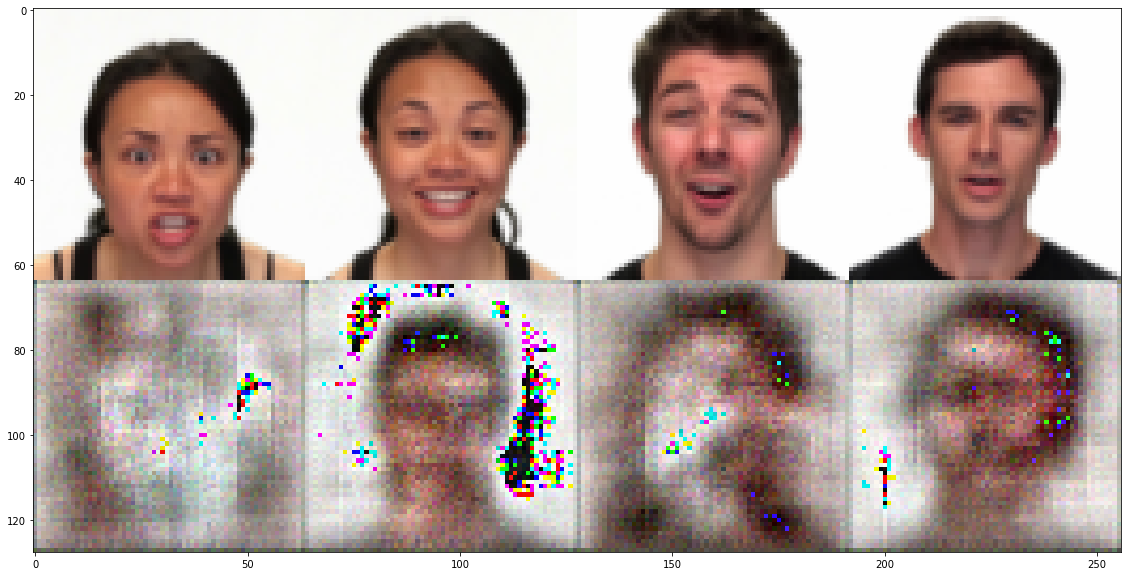

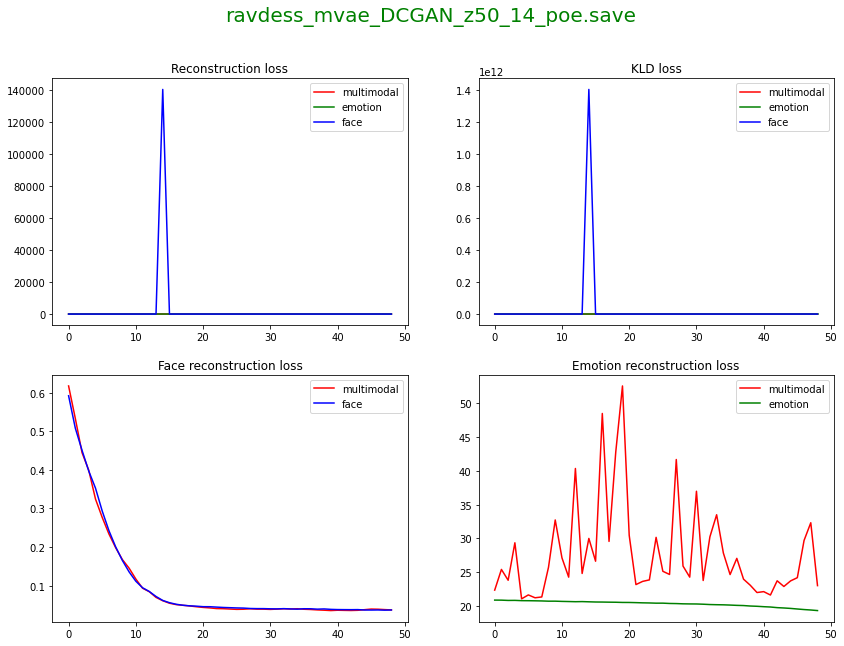

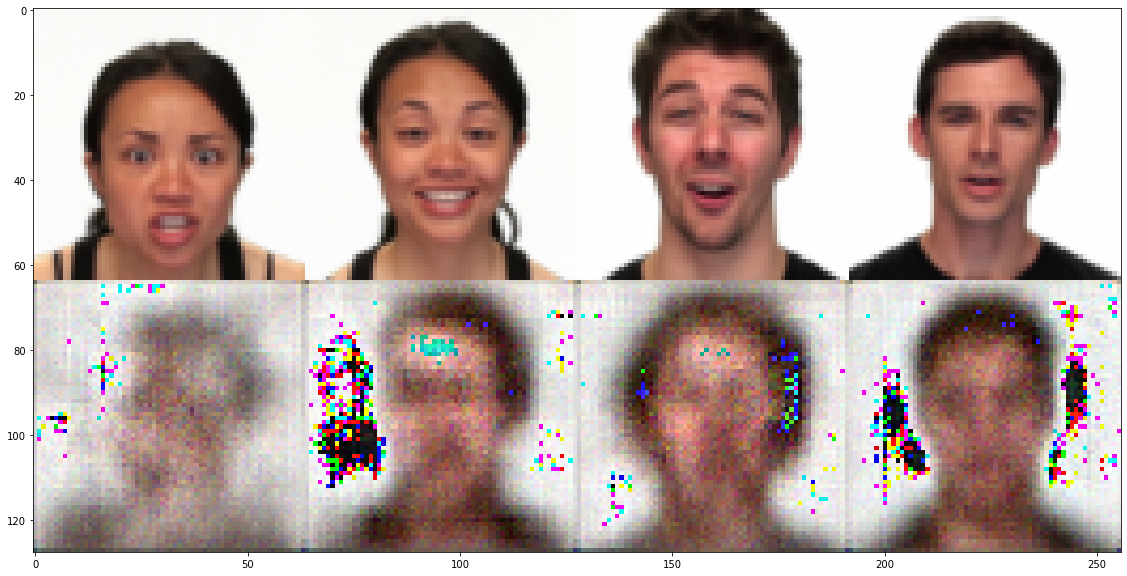

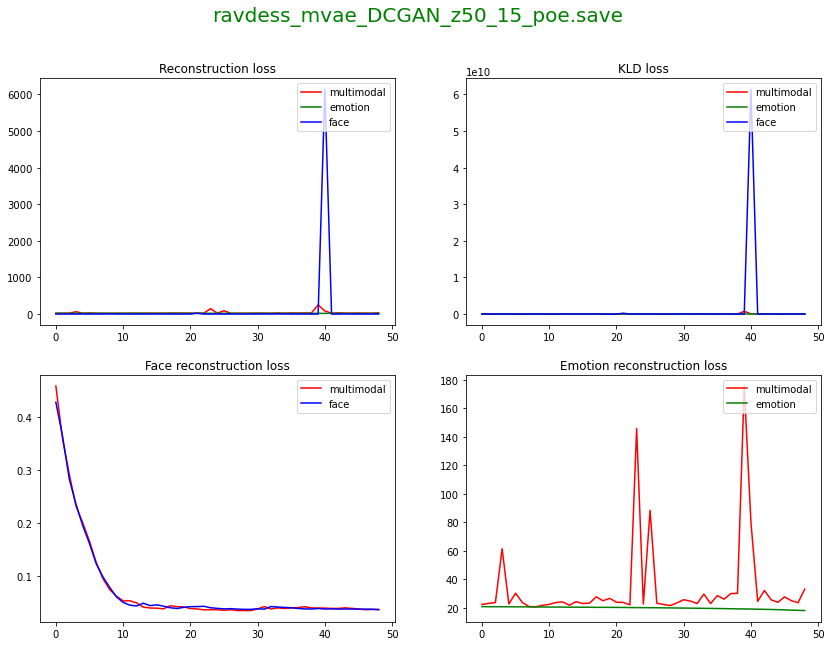

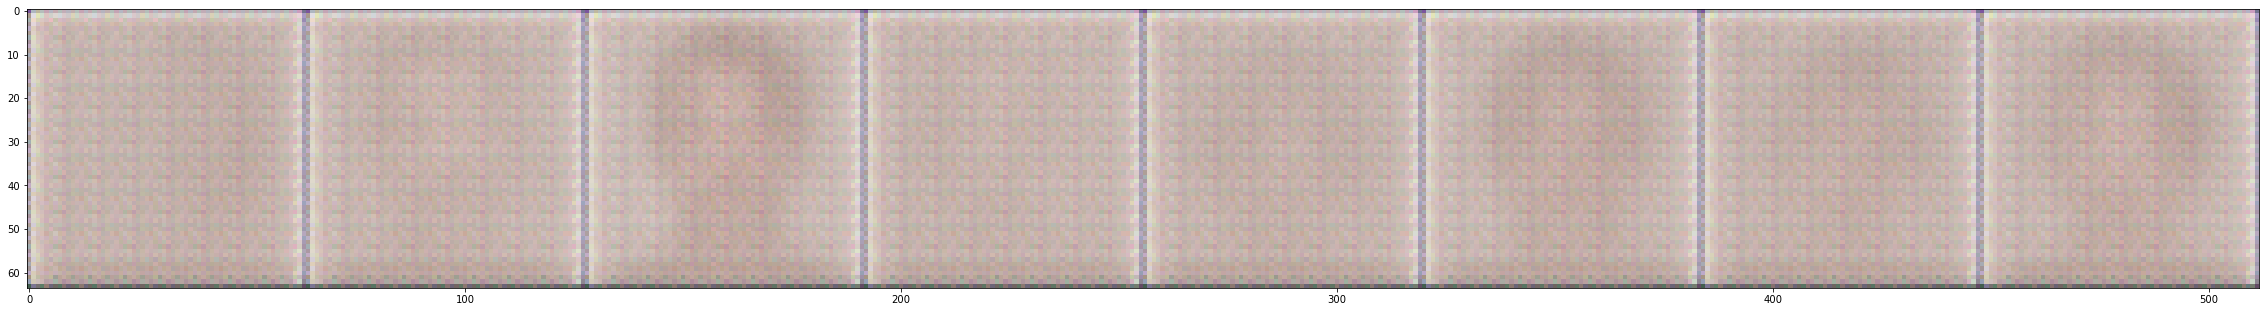

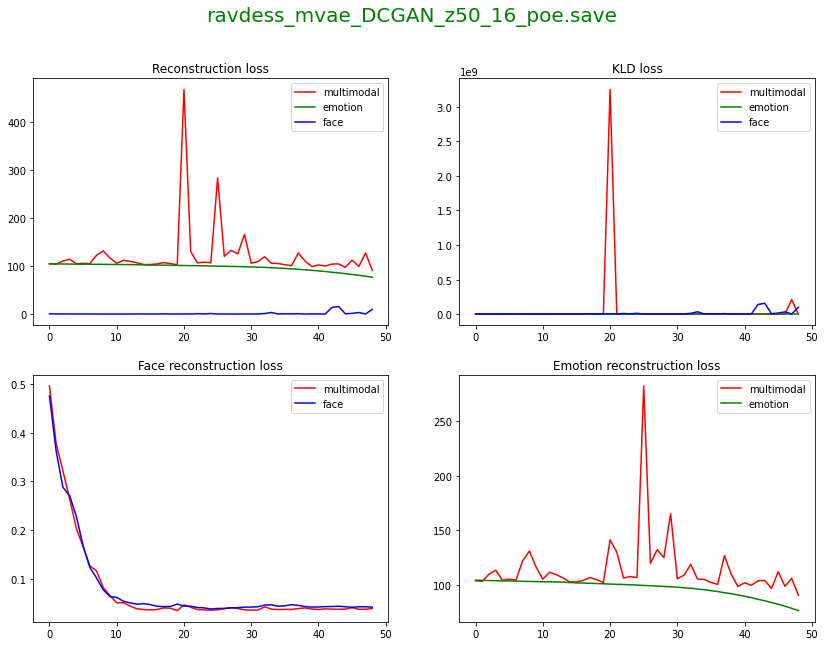

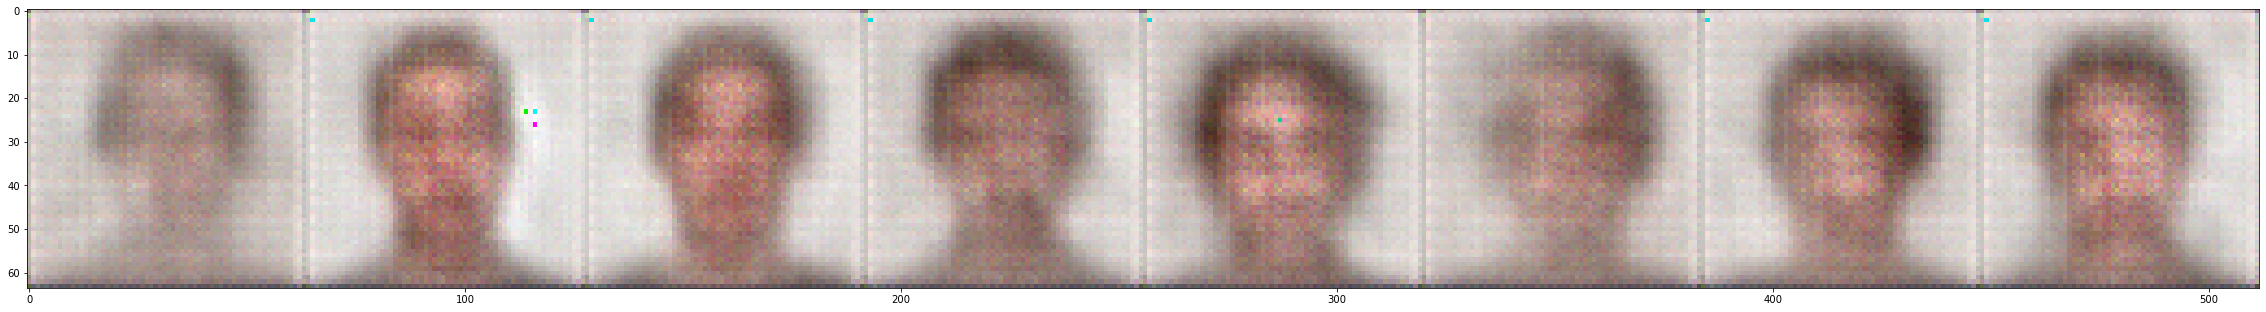

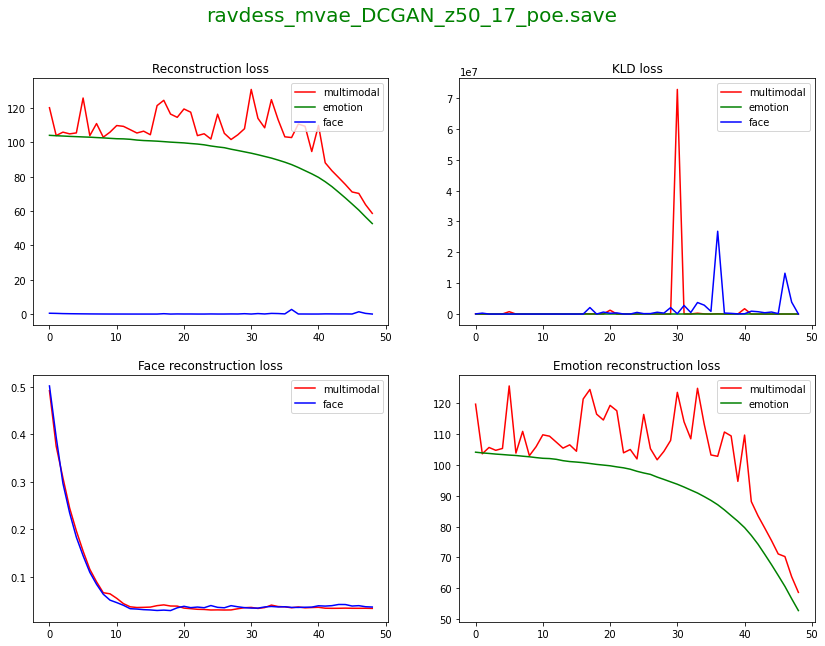

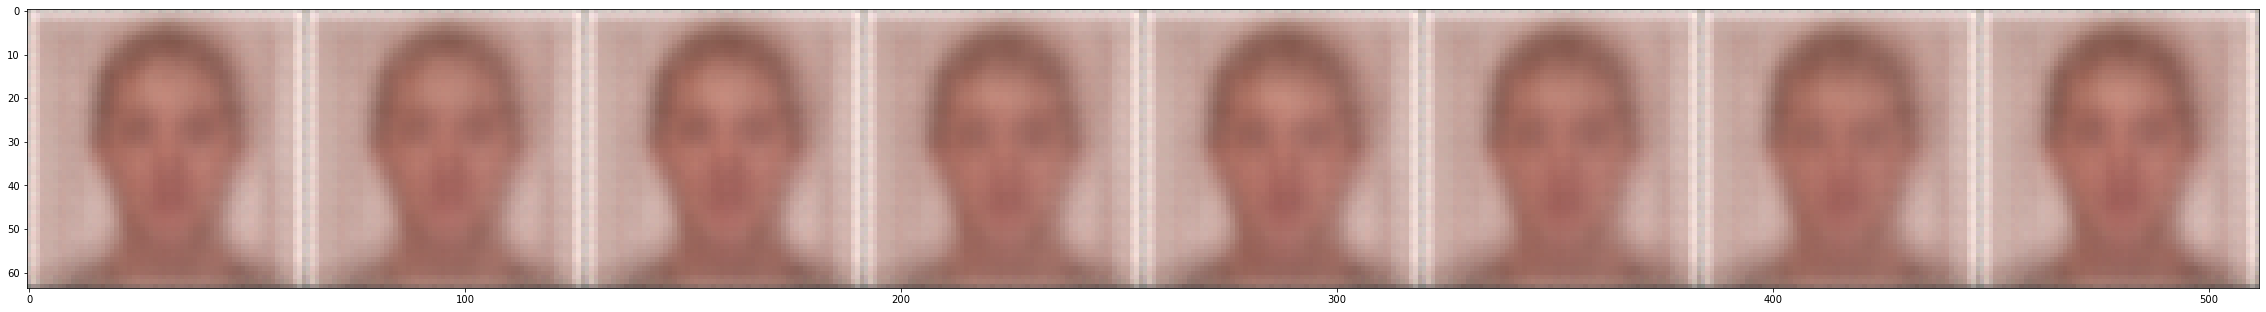

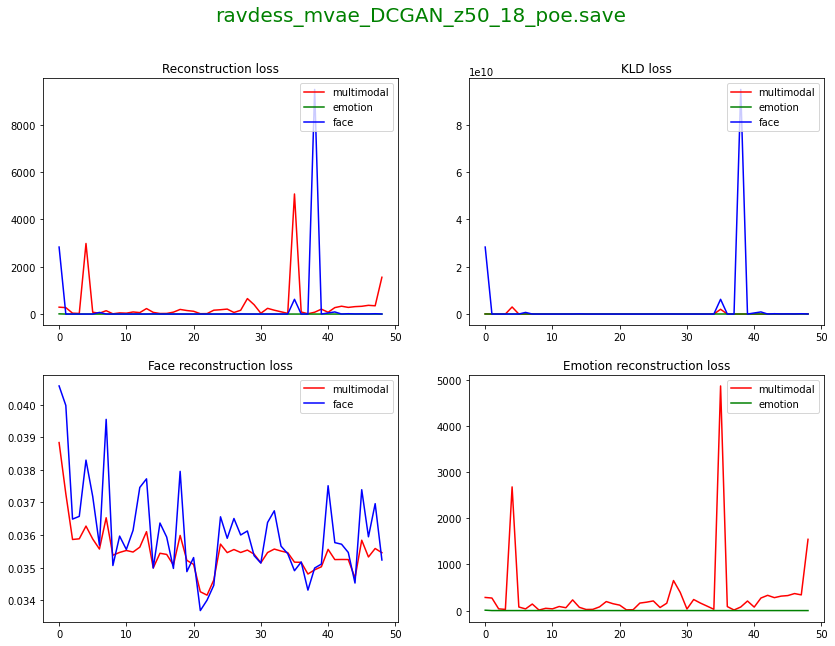

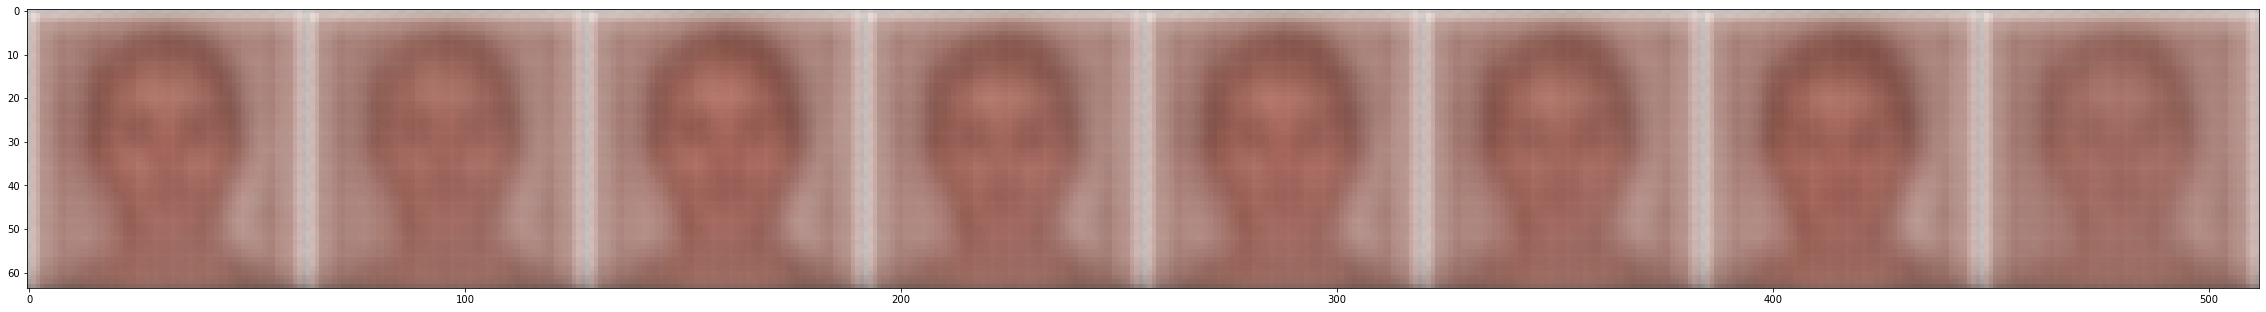

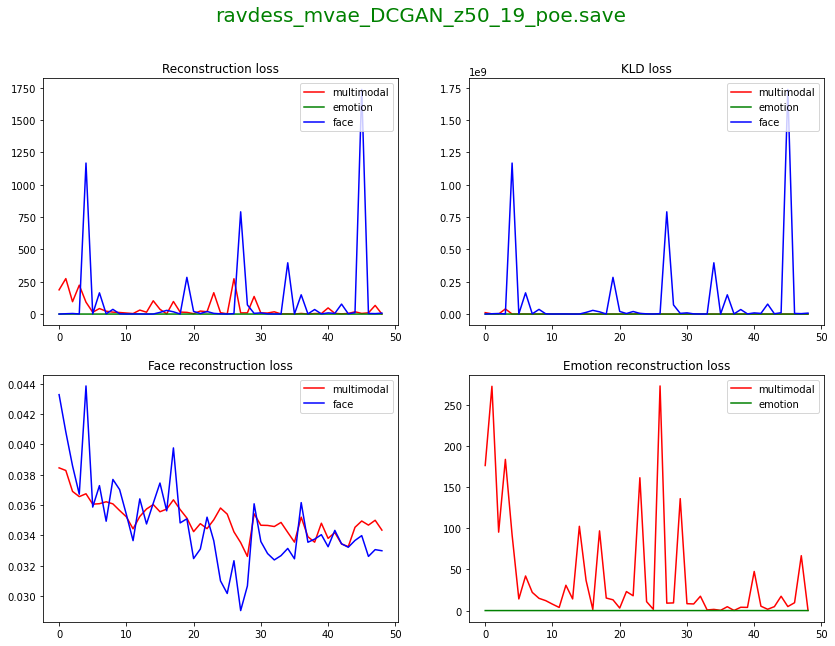

In [4]:
folder_path = "../trained_models/"

model_name = ["ravdess_mvae_DCGAN_z50_00.save",
              "ravdess_mvae_DCGAN_z50_01.save",
              "ravdess_mvae_DCGAN_z50_02.save",
              "ravdess_mvae_DCGAN_z50_03.save",
              "ravdess_mvae_DCGAN_z50_04.save",
              "ravdess_mvae_DCGAN_z50_05.save",
              "ravdess_mvae_DCGAN_z50_06.save",
              "ravdess_mvae_DCGAN_z50_08.save",
              "ravdess_mvae_DCGAN_z50_09_poe.save",
              "ravdess_mvae_DCGAN_z50_12_altloss.save",
             ]

model_name_poe = ["ravdess_mvae_DCGAN_z50_13_poe.save",
                  "ravdess_mvae_DCGAN_z50_14_poe.save",
                  "ravdess_mvae_DCGAN_z50_15_poe.save",
                  "ravdess_mvae_DCGAN_z50_16_poe.save",
                  "ravdess_mvae_DCGAN_z50_17_poe.save",
                  "ravdess_mvae_DCGAN_z50_18_poe.save",
                  "ravdess_mvae_DCGAN_z50_19_poe.save",]

def print_faces(model_names):
    for model_name in model_names:
        loaded_data = torch.load(folder_path + model_name)
        
        losses = loaded_data['training_loss']
        model_args = loaded_data['model_args']
        display_array = loaded_data['rec_image']
        plt.figure(figsize = (40,10))
        
        plt.imshow(display_array)
        U.print_losses(losses , model_name, 1)
        #U.print_losses(losses)
        #plt.title(model_name, fontsize=30,color="green")
        
        
print_faces(model_name_poe)

In [5]:
loaded_data = torch.load(folder_path + model_names[0])
model: torch.nn.Module = build_model(**loaded_data['model_args']).double()
model.load_state_dict(loaded_data['model_params'])
model.eval()

U.test_batch(model, testset_loader)

NameError: name 'model_names' is not defined

['neutral', 'surprised', 'angry', 'sad']
['neutral', 'surprised', 'angry', 'sad']


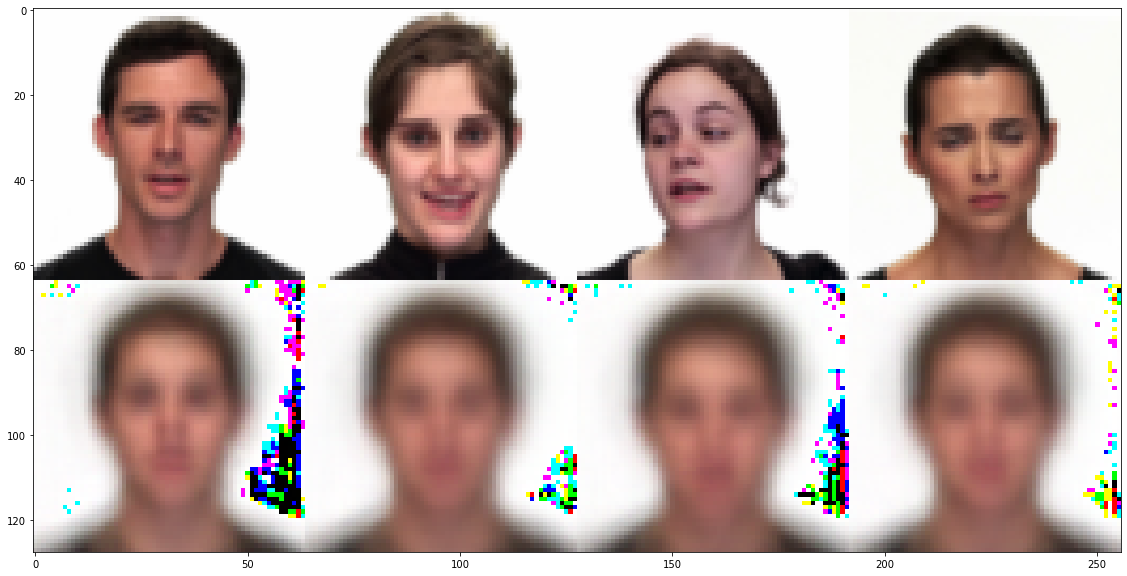

In [9]:
loaded_data = torch.load(folder_path + model_names[1])
model: torch.nn.Module = build_model(**loaded_data['model_args']).double()
model.load_state_dict(loaded_data['model_params'])
model.eval()

U.test_batch(model, testset_loader)

['fearful', 'surprised', 'disgust', 'neutral']
['fearful', 'surprised', 'disgust', 'surprised']


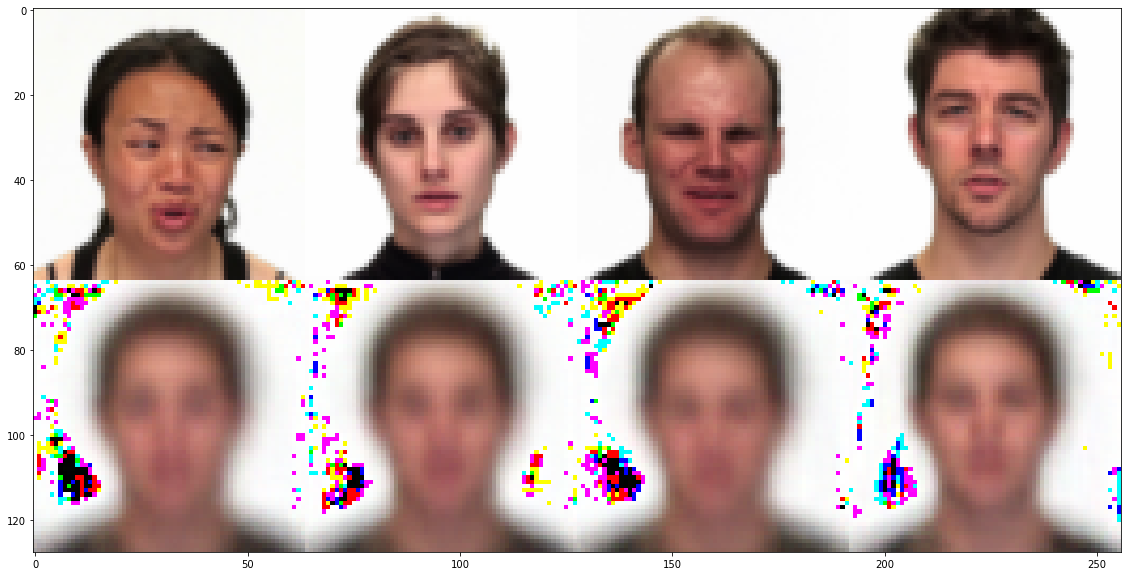

In [10]:
loaded_data = torch.load(folder_path + model_names[2])
model: torch.nn.Module = build_model(**loaded_data['model_args']).double()
model.load_state_dict(loaded_data['model_params'])
model.eval()

U.test_batch(model, testset_loader)

In [ ]:
import matplotlib.pyplot as plt
Rd.emocat

In [ ]:
emotion = 2
print(Rd.emocat[emotion])

emotion = torch.tensor([emotion]).to('cuda')
plt.figure(figsize = (5,5))
r_image, _, _, _ = model(faces=None, emotions=emotion)
_, r_emotion, _, _ = model(faces=r_image, emotions=None)
r_image = torch.clamp(r_image, min=0, max=1)
r_image = np.array(r_image.cpu().detach().numpy()[0]).transpose((1, 2, 0))
plt.imshow(r_image)
print((Rd.emocat[torch.argmax(r_emotion.cpu()).item()]))